In [48]:
import numpy as np
import matplotlib.pyplot as plt

In [49]:
num_flip_flops = 6  # Número de flip-flops para a m-sequence
num_symbols = 1000  # Número de símbolos transmitidos por iteração
num_iterations = 1000  # Número de iterações (pode ser ajustado facilmente)
eb_n0_db = np.arange(0, 24, 1)  # Intervalo de Eb/N0 em dB

mod_order = 8  # Ordem da modulação 8-PSK
bits_per_symbol = int(np.log2(mod_order))  # Número de bits por símbolo (3 para 8-PSK)

# Comprimento do código de espalhamento (m-sequence)
code_length = (2**num_flip_flops) - 1

In [50]:
def generate_msequence(num_flip_flops, initial_state):
    """
    Gera uma sequência máxima (m-sequence) utilizando um registrador de deslocamento (LFSR)
    com taps no primeiro e no último bit.
    """
    N = (2**num_flip_flops) - 1
    state = initial_state.copy()
    sequence = np.zeros(N)
    for i in range(N):
        # Usa o último bit como saída
        sequence[i] = state[-1]
        # Novo bit: soma módulo 2 do primeiro e do último bits (equivalente a XOR)
        new_bit = (state[0] + state[-1]) % 2
        state = np.roll(state, 1)
        state[0] = new_bit
    return sequence


# Estado inicial (pode ser escolhido arbitrariamente, mas não nulo)
initial_state = np.array([0, 1, 1, 1, 1, 1])
m_sequence = generate_msequence(num_flip_flops, initial_state)

# Converte a sequência para valores bipolares {-1, +1} e normaliza para energia unitária
base_code = 2 * m_sequence - 1
base_code = base_code / np.sqrt(len(base_code))

In [51]:
# Conforme o enunciado: 3 usuários transmitindo simultaneamente,
# com 2 interferindo no sinal do terceiro. Definimos:
#   - Usuário desejado: código deslocado em 10 posições.
#   - Usuários interferentes: o primeiro utiliza o código base e o segundo, código base deslocado em 5.
interf_code1 = base_code.copy()  # Usuário interferente 1
interf_code2 = np.roll(base_code, 5)  # Usuário interferente 2
desired_code = np.roll(base_code, 10)  # Usuário desejado

In [52]:
def modulate_8psk(bits):
    """
    Modula os bits em símbolos 8-PSK.
    - bits: array com dimensão (num_symbols, bits_per_symbol)
    Retorna um array de símbolos complexos (energia unitária).
    """
    # Converte cada linha (símbolo) para um inteiro (MSB primeiro)
    integers = bits.dot(2 ** np.arange(bits.shape[1] - 1, -1, -1))
    # Mapeamento para 8-PSK
    symbols = np.exp(1j * 2 * np.pi * integers / mod_order)
    return symbols


def demodulate_8psk(symbols):
    """
    Demodula um array 1D de símbolos 8-PSK.
    Retorna:
      - bits: array com dimensão (num_symbols, bits_per_symbol)
      - decision: array de inteiros (0 a mod_order-1) correspondentes aos símbolos demodulados.
    """
    symbols = np.asarray(symbols).flatten()
    angles = np.angle(symbols)
    angles[angles < 0] += 2 * np.pi  # Ajusta para o intervalo [0, 2π]
    decision = np.round(angles / (2 * np.pi / mod_order)) % mod_order
    decision = decision.astype(int)
    # Conversão vetorizada dos inteiros para bits (MSB primeiro)
    bits = (
        (decision[:, None] & (1 << np.arange(bits_per_symbol - 1, -1, -1))) > 0
    ).astype(int)
    return bits, decision

In [53]:
# Vetores para armazenar a BER para cada Eb/N0
ber_single_user = np.zeros(len(eb_n0_db))
ber_multi_user = np.zeros(len(eb_n0_db))

# Número total de bits transmitidos por valor de Eb/N0 (para cálculo da BER)
total_bits = num_symbols * bits_per_symbol * num_iterations

for idx, eb_n0_db_val in enumerate(eb_n0_db):
    eb_n0_linear = 10 ** (eb_n0_db_val / 10)
    # Considerando sinal modulado unitário: Es = 1, logo Eb = Es / bits_per_symbol
    eb = 1 / bits_per_symbol
    # sigma: desvio-padrão do ruído (canal AWGN complexo)
    sigma = np.sqrt(eb / (2 * eb_n0_linear))

    errors_single = 0
    errors_multi = 0

    for _ in range(num_iterations):
        # --------------- Cenário Single User (Sem interferência) ---------------
        # Gera bits aleatórios para o usuário desejado
        tx_bits = np.random.randint(0, 2, num_symbols * bits_per_symbol)
        tx_bits_reshape = tx_bits.reshape(-1, bits_per_symbol)
        tx_symbols = modulate_8psk(
            tx_bits_reshape
        )  # Vetor de símbolos (tamanho: num_symbols)

        # Espalhamento: cada símbolo é espalhado utilizando o código do usuário desejado
        # Resultado: matriz de dimensão (code_length, num_symbols)
        spread_signal = desired_code[:, None] * tx_symbols
        tx_signal = spread_signal.flatten()

        # Canal AWGN
        noise = sigma * (
            np.random.randn(*tx_signal.shape) + 1j * np.random.randn(*tx_signal.shape)
        )
        rx_signal = tx_signal + noise

        # Reorganiza o sinal recebido na forma de matriz (para corresponder aos chips)
        rx_matrix = rx_signal.reshape(len(desired_code), num_symbols)

        # Desespalhamento: correlação com o código do usuário desejado
        despread_signal = np.sum(rx_matrix * desired_code[:, None], axis=0)

        # Demodulação 8-PSK
        rx_bits, _ = demodulate_8psk(despread_signal)
        rx_bits = rx_bits.flatten()

        errors_single += np.sum(rx_bits != tx_bits)

        # --------------- Cenário Multiusuário (Com interferência) ---------------
        # Gera bits para cada usuário
        # Usuário desejado
        desired_bits = np.random.randint(0, 2, num_symbols * bits_per_symbol)
        desired_bits_reshape = desired_bits.reshape(-1, bits_per_symbol)
        desired_symbols = modulate_8psk(desired_bits_reshape)

        # Usuário interferente 1
        interf1_bits = np.random.randint(0, 2, num_symbols * bits_per_symbol)
        interf1_bits_reshape = interf1_bits.reshape(-1, bits_per_symbol)
        interf1_symbols = modulate_8psk(interf1_bits_reshape)

        # Usuário interferente 2
        interf2_bits = np.random.randint(0, 2, num_symbols * bits_per_symbol)
        interf2_bits_reshape = interf2_bits.reshape(-1, bits_per_symbol)
        interf2_symbols = modulate_8psk(interf2_bits_reshape)

        # Espalhamento para cada usuário
        desired_signal = desired_code[:, None] * desired_symbols
        interf1_signal = interf_code1[:, None] * interf1_symbols
        interf2_signal = interf_code2[:, None] * interf2_symbols

        # Sinal transmitido total: soma dos sinais dos 3 usuários
        tx_multi_signal = desired_signal + interf1_signal + interf2_signal
        tx_multi_signal_serial = tx_multi_signal.flatten()

        # Adição do ruído no canal
        noise_multi = sigma * (
            np.random.randn(*tx_multi_signal_serial.shape)
            + 1j * np.random.randn(*tx_multi_signal_serial.shape)
        )
        rx_multi_signal = tx_multi_signal_serial + noise_multi

        # Reorganiza o sinal recebido
        rx_multi_matrix = rx_multi_signal.reshape(len(desired_code), num_symbols)

        # Desespalhamento utilizando o código do usuário desejado
        despread_signal_multi = np.sum(rx_multi_matrix * desired_code[:, None], axis=0)

        # Demodulação do sinal desejado
        rx_bits_multi, _ = demodulate_8psk(despread_signal_multi)
        rx_bits_multi = rx_bits_multi.flatten()

        errors_multi += np.sum(rx_bits_multi != desired_bits)

    # Cálculo da BER para o Eb/N0 atual
    ber_single_user[idx] = errors_single / total_bits
    ber_multi_user[idx] = errors_multi / total_bits

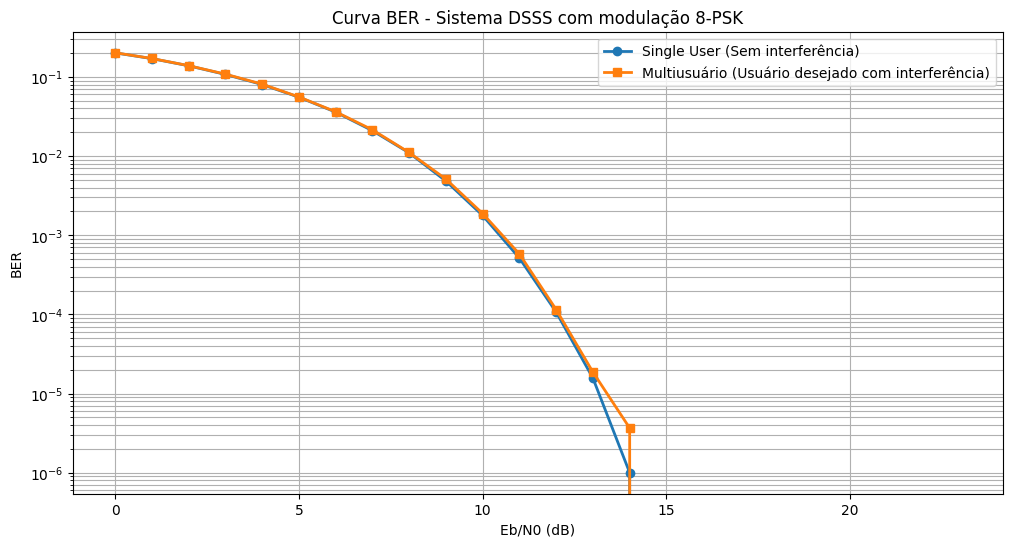

In [54]:
plt.figure(figsize=(12, 6))
plt.semilogy(
    eb_n0_db,
    ber_single_user,
    "o-",
    linewidth=2,
    label="Single User (Sem interferência)"
)
plt.semilogy(
    eb_n0_db,
    ber_multi_user,
    "s-",
    linewidth=2,
    label="Multiusuário (Usuário desejado com interferência)"
)
plt.xlabel("Eb/N0 (dB)")
plt.ylabel("BER")
plt.title("Curva BER - Sistema DSSS com modulação 8-PSK")
plt.grid(True, which="both")
plt.legend()
plt.show()